<img src="https://thevalley.es/wp-content/uploads/2016/11/thevalley-logo-negro.png" width="400"></img>

# Introducción a medidas de proximidad y similitud

<img src="https://github.com/davidreyblanco/ml-training/blob/master/resources/distance.jpg?raw=true" width="200"></img>
    
*Autor*: David Rey

*Recursos*: Los códigos de esta sesión y recursos se pueden encontra en el [repositorio](https://github.com/davidreyblanco/ml-training) 
<br/>
<hr/>

Las medidas de *proximidad* indican lo que se parecen o no cada una de nuestras observaciones (o registros, según el dialecto que utilicemos), a menudo se utilizan indistintamente los términos de proximidad o similitud. Todos se refieren al mismo concepto pero existen ligeras diferencias.

* *Proximidad* se refiere a ambos términos
* La *similitud* y *disimilitud* son magnitudes recíprocas (un va al contrario de la otra)
* Se puede definir una función que transforme de similitud a disimilitud
* La *Distancia* se suele usar como sinónimo, pero es un caso particular de disimilitud
* Si la llevamos números, la similitud en general suele expresarse dentro del intervalo [0-1] pero en ocasiones también se usa [0-infinito] o [-inf,+inf]

### Propiedades de las métricas de distancia (en los espacios vectoriales con vectores con norma)

* No negatividad: d(x, y) >= 0
* Identidad: d(x, y) = 0 if and only if x == y
* Simetría: d(x, y) = d(y, x)
* Desigualdad triangular: d(x, y) + d(y, z) >= d(x, z)

## Conjuntos de datos
Los ejemplos se han sacado de varios conjuntos de datos públicos de Kaggle

**Calificaciones de estudiantes**

El primer dataset cuenta con [Resultados de estudiantes](https://github.com/davidreyblanco/ml-training/blob/master/data/StudentsPerformance.csv) y su fuente original es http://roycekimmons.com/tools/generated_data/exams

**El tiempo en australia**
This dataset contains about 10 years of daily weather observations from many locations across Australia.
RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.
Source & Acknowledgements
Observations were drawn from numerous weather stations. The daily observations are available from http://www.bom.gov.au/climate/data.
An example of latest weather observations in Canberra: http://www.bom.gov.au/climate/dwo/IDCJDW2801.latest.shtml

Definitions adapted from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml
Data source: http://www.bom.gov.au/climate/dwo/ and http://www.bom.gov.au/climate/data.


In [28]:
# Carga de librerias
import numpy as np
import pandas as pd
import sys
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# Ignoramos los warning que no quedan muy bien
import warnings
warnings.filterwarnings('ignore')
# To determine which version you're using:
#!pip show seaborn
#!pip install --upgrade seaborn

[Info sobre como importar librerías en colab](https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb#scrollTo=6km1lWMF2kAm)

In [29]:
# Cargamos de los datos del tiempo en australia
df_weather = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/weatherAUS.csv')
df_weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [30]:
# Carga de datos de resultados de alumnos (transformamos la escala de la puntuación de lectura)
df_students = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/StudentsPerformance.csv')
df_students['reading score'] = df_students['reading score'] / 100
df_students.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,0.72,74
1,female,group C,some college,standard,completed,69,0.90,88
2,female,group B,master's degree,standard,none,90,0.95,93
3,male,group A,associate's degree,free/reduced,none,47,0.57,44
4,male,group C,some college,standard,none,76,0.78,75


## Medidas básicas de distancia

De forma intuitiva podemos pensar en medidas de distancia entre variables sencillas como la edad o altura, o niveles de gasto. Para ello vamos a ver las diferencias entre las notas en matemáticas del alumno 1 y el 2 del conjunto de datos de los estudiantes.

In [31]:
# Calculamos la distancia como la diferencia en valor absoluto, ¿es una distancia euclídea?
puntos_alumno_1 = df_students['math score'][0]
puntos_alumno_2 = df_students['math score'][1]
print('Puntos alumno 1: '+ str(puntos_alumno_1))
print('Puntos alumno 2: '+ str(puntos_alumno_2))
print('Distancia / diferencia en matemáticas: '+ str(abs(puntos_alumno_1 - puntos_alumno_2)))

Puntos alumno 1: 72
Puntos alumno 2: 69
Distancia / diferencia en matemáticas: 3


In [32]:
# Ahora lo hacemos con las notas de lectura
puntos_alumno_1 = df_students['reading score'][0]
puntos_alumno_2 = df_students['reading score'][1]
print('Puntos alumno 1: '+ str(puntos_alumno_1))
print('Puntos alumno 2: '+ str(puntos_alumno_2))
print('Distancia / diferencia en lectura: '+ str(abs(puntos_alumno_1 - puntos_alumno_2)))

Puntos alumno 1: 0.72
Puntos alumno 2: 0.9
Distancia / diferencia en lectura: 0.18000000000000005


mmmmm....., ¿es mas parecida la nota en matematicas que en lectura?, ¿y si quisiéramos calcular la diferencia en notas? 

In [33]:
distancia_notas_math = abs(df_students['math score'][0] - df_students['math score'][1])
distancia_notas_reading = abs(df_students['reading score'][0] - df_students['reading score'][1])
distancia_notas_writing = abs(df_students['writing score'][0] - df_students['writing score'][1])
distancia_notas = distancia_notas_math + distancia_notas_reading + distancia_notas_writing
print('Distancia / total: '+ str(distancia_notas))

Distancia / total: 17.18


Hemos hecho ya nuestra primera distancia, **¿qué distancia hemos calculado?**, ¿qué pasa si vamos incluyendo más dimensiones en la distancia?

## Transformaciones básicas de los datos

Sin embargo en los conjuntos de datos tenemos datos de distinta naturaleza, como pueden ser categóricos ordinales e incluso texto, ¿qué podemos hacer con los categóricos para sacar una medida de distancia?.
Primero mostramos la distribución de frecuencias con un histograma sobre la variable de notas en lectura, vemos que el rango está entre 0.17 y 1.0

0.17 1.0


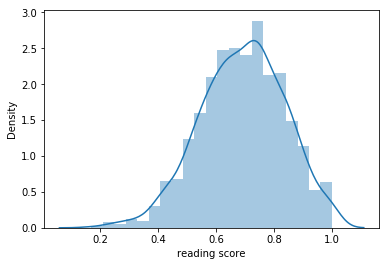

In [34]:
sns.distplot((df_students['reading score']))
print(min(df_students['reading score']),max(df_students['reading score']))

Hacemos lo mismo con las notas en matemáticas, vemos que el rango de la variable no tiene nada que ver

0 100


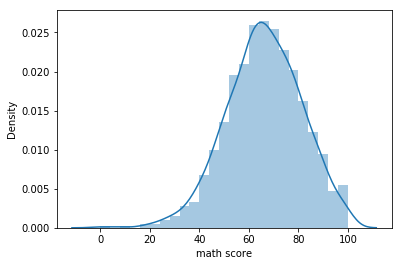

In [35]:
sns.distplot((df_students['math score']))
print(min(df_students['math score']),max(df_students['math score']))

¿Qué pasa si mezclamos ambas magnitudes?, podríamos mezclar estas distancias ... no parece buena idea

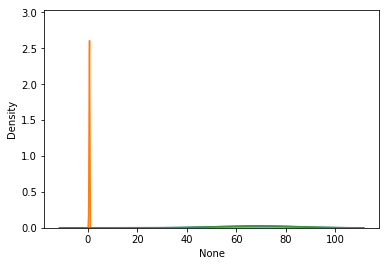

In [36]:
sns.distplot([df_students['math score']])
sns.distplot([df_students['reading score']])             
sns.distplot([df_students['writing score']])    

Una solución sería *normalizar* la magnitud y llevar todas las variables a una escala de 0 a 1, dónde 0 es el minimo y 1 es el máximo:
    
$ x_{normalizada} = \frac{x - min(x)}{max(x)-min(x)}$

*Nota*: siendo estrictos no estamos realizando una normalización


In [37]:
df_students['norm reading score'] = (df_students['reading score'] - min(df_students['reading score'])) / (max(df_students['reading score']) - min(df_students['reading score']))
df_students['norm math score'] = (df_students['math score'] - min(df_students['math score'])) / (max(df_students['math score']) - min(df_students['math score']))
df_students['norm writing score'] = (df_students['writing score'] - min(df_students['writing score'])) / (max(df_students['writing score']) - min(df_students['writing score']))

Vemos que ahora tiene mejor aspecto

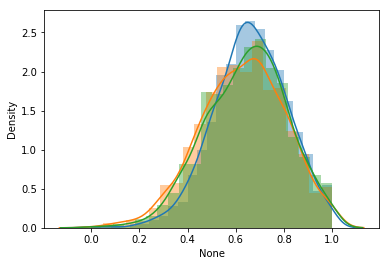

In [38]:
sns.distplot([df_students['norm math score']])
sns.distplot([df_students['norm reading score']])   
sns.distplot([df_students['norm writing score']])   

En realidad en scikit learn hay una gran cantidad de utilidades para el preprocesado de variables, lo que hemos hecho es equivalente a el **MaxMinScaler**. Para más información https://scikit-learn.org/stable/modules/preprocessing.html

In [39]:
from sklearn import preprocessing
features = ['reading score', 'math score', 'writing score']
scaler_df = preprocessing.MaxAbsScaler().fit(df_students[features].values)

normalized_values = scaler_df.transform(df_students[features].values)

normalized_df = pd.DataFrame(normalized_values, columns=features)

Vemos que obtenemos exactamente lo mismo

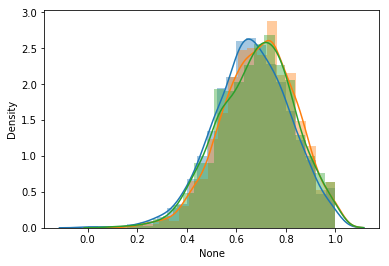

In [40]:
sns.distplot([normalized_df['math score']])
sns.distplot([normalized_df['reading score']])   
sns.distplot([normalized_df['writing score']])   

# Distancias sobre magnitudes numéricas


## Distancia euclídea

La distancia euclidiana o métrica euclidiana es la distancia "ordinaria" (es decir, en línea recta) entre dos puntos, es una medida de distancia e intuitiva que se aplica facilmente a valores numéricos. De forma general la distancia entre la observación p y q, siendo ambos vectores de dimensión $n$, se calcularía como:
$$ \sqrt{\sum_{i=1}^{n}{(p_i-q_i)^2}}$$
Sólo para los amantes del álgebra es una medida aplicable a un [espacio euclídeo](https://es.wikipedia.org/wiki/Espacio_eucl%C3%ADdeo), elementos que por sus propiedades han servido de base para generar gran cantidad de conceptos matemáticos relacionados con la geometría analítica, la topología, el álgebra y el cálculo.

In [41]:
df_students['euclidean'] = None
for i in range(0,10):
    d2 = np.square( df_students['norm reading score'][i] - df_students['norm reading score'][i+1] )  
    d2 += np.square( df_students['norm math score'][i] - df_students['norm math score'][i+1] )  
    d2 += np.square( df_students['norm writing score'][i] - df_students['norm writing score'][i+1] )  
    df_students['euclidean'][i] = np.sqrt( d2 )
df_students.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,norm reading score,norm math score,norm writing score,euclidean
0,female,group B,bachelor's degree,standard,none,72,0.72,74,0.662651,0.72,0.711111,0.268568
1,female,group C,some college,standard,completed,69,0.90,88,0.879518,0.69,0.866667,0.225423
2,female,group B,master's degree,standard,none,90,0.95,93,0.939759,0.90,0.922222,0.831222
3,male,group A,associate's degree,free/reduced,none,47,0.57,44,0.481928,0.47,0.377778,0.516485
4,male,group C,some college,standard,none,76,0.78,75,0.734940,0.76,0.722222,0.0850887


## Distancia manhattan

La geometría del taxi (taxicab) es una forma de geometría en la que la métrica habitual de la geometría euclidiana se reemplaza por una nueva métrica en la que la distancia entre dos puntos es la suma de las diferencias (absolutas) de sus coordenadas.
La distancia de Manhattan, también conocida como *distancia rectilínea*, distancia de **bloque** de la ciudad, métrica de taxi se define como la suma de las longitudes de las proyecciones del segmento de línea entre los puntos en los ejes de coordenadas.
En ajedrez, la distancia entre casillas del tablero de ajedrez para torres se mide en distancia de Manhattan.

Se calula como:
$$ \sum_{i=1}^{n}{|p_i-q_i|}$$

In [42]:
df_students['manhattan'] = None
for i in range(0,10):
    d2 = abs( df_students['norm reading score'][i] - df_students['norm reading score'][i+1] )  
    d2 += abs( df_students['norm math score'][i] - df_students['norm math score'][i+1] )  
    d2 += abs( df_students['norm writing score'][i] - df_students['norm writing score'][i+1] )  
    df_students['manhattan'][i] = np.sqrt( d2 )


Comparamos ambas medidas, vemos como no existe una relación constante en ambas medidas, ¿qué pasa en la observación número 4?, por qué la proporción es aproximadamente 4.5 y la media es 

In [43]:
df_students['ratio manhattan/euclidean'] = df_students['manhattan'] / df_students['euclidean']
df_students[['norm reading score',
             'norm math score',
             'norm writing score',
             'euclidean', 
             'manhattan',
             'ratio manhattan/euclidean']].head(10)

,norm reading score,norm math score,norm writing score,euclidean,manhattan,ratio manhattan/euclidean
0,0.662651,0.72,0.711111,0.268568,0.634368,2.36204
1,0.879518,0.69,0.866667,0.225423,0.570786,2.53207
2,0.939759,0.90,0.922222,0.831222,1.19678,1.43978
3,0.481928,0.47,0.377778,0.516485,0.942049,1.82396
4,0.734940,0.76,0.722222,0.0850887,0.378912,4.45314
5,0.795181,0.71,0.755556,0.27203,0.685663,2.52054
6,0.939759,0.88,0.911111,0.984733,1.30207,1.32226
7,0.313253,0.40,0.322222,0.467338,0.896729,1.9188
8,0.566265,0.64,0.633333,0.324964,0.70504,2.1696
9,0.518072,0.38,0.444444,0.213821,0.542689,2.53805


Distancias sobre atributos no numéricos (manhattan y euclídea)


## Distancia coseno
En este ejemplo vamos a calcular la distancia coseno dos vectores, como adelantamos es una medida utilizada para comparar documentos o incluso diferencias entre variables dummy.

In [44]:
def cosine_similarity(x,y):    
    x_norm = math.sqrt(sum([x_i*x_i for x_i in x]))
    y_norm = math.sqrt(sum([y_i*y_i for y_i in y]))
    numerator = sum(x_i*y_i for x_i,y_i in zip(x,y)) # x * y
    denominator = x_norm * y_norm # |x| * |y|    
    return round(numerator/float(denominator),5)

# Calculamos la disimilitud coseno como 1 - sim_coseno
def cosine_disimilarity(x,y):        
    return 1 - cosine_similarity(x,y)


In [45]:
# Ejemplos
print(cosine_similarity([3, 45, 7, 2], [2, 54, 13, 15]))

# Se hace máxima cuando son el mismo vector
print(cosine_similarity([2, 54, 13, 15], [2, 54, 13, 15]))

# Se hace mínima cuando son ortogonales
print(cosine_similarity([0, 1,0], [1,0,1]))

0.97228
1.0
0.0


Preguntas:

*pregunta 1)* ¿puede ser la distancia coseno negativa?

*pregunta 2)* Ejercicio rápido, calcular las distancia coseno, euclídea y manhattan entre estos dos vectores, ¿alguna conclusión?

| perro| gato | elefante |
| -----------| ----------- | ----------- |
| 1| 0 | 0 |
| 0| 1 | 0 |       

## Distancia hamming


In [46]:
def hamming_distance(x,y, normalized = False):    
    list_x = list(x)
    list_y = list(y)
    print('x = ' + str(list_x))
    print('y = ' + str(list_y))
    distance = sum(x_i == y_i  for x_i,y_i in zip(list_x,list_y)) # x * y
    if normalized:
        distance = distance / len(x) 
    return distance
print(hamming_distance('hola','bolo', normalized = True)) # Valor de 0 a 1
print(hamming_distance('hola','bolo', normalized = False))# Valor de 0 a longitud de la cadena

x = ['h', 'o', 'l', 'a']
y = ['b', 'o', 'l', 'o']
0.5
x = ['h', 'o', 'l', 'a']
y = ['b', 'o', 'l', 'o']
2


In [47]:
# Partimos de una lista de 3 palabras
input_str = ['carolina', 'kathrina', 'kristina', 'kristona',  'krisnald','calorina','calorett']
# Partimos de una lista de 3 palabras
for i in range(1,7):
    print(hamming_distance(input_str[0],input_str[i], normalized = True)) # Valor de 0 a 1

x = ['c', 'a', 'r', 'o', 'l', 'i', 'n', 'a']
y = ['k', 'a', 't', 'h', 'r', 'i', 'n', 'a']
0.5
x = ['c', 'a', 'r', 'o', 'l', 'i', 'n', 'a']
y = ['k', 'r', 'i', 's', 't', 'i', 'n', 'a']
0.375
x = ['c', 'a', 'r', 'o', 'l', 'i', 'n', 'a']
y = ['k', 'r', 'i', 's', 't', 'o', 'n', 'a']
0.25
x = ['c', 'a', 'r', 'o', 'l', 'i', 'n', 'a']
y = ['k', 'r', 'i', 's', 'n', 'a', 'l', 'd']
0.0
x = ['c', 'a', 'r', 'o', 'l', 'i', 'n', 'a']
y = ['c', 'a', 'l', 'o', 'r', 'i', 'n', 'a']
0.75
x = ['c', 'a', 'r', 'o', 'l', 'i', 'n', 'a']
y = ['c', 'a', 'l', 'o', 'r', 'e', 't', 't']
0.375


# Distancia Jaccard

In [48]:
def jaccard_similarity(x,y):    
    set_x = set(x)
    set_y = set(y)
    print('------------------------------------------------')
    print('x = ' + str(set_x))
    print('y = ' + str(set_y))
    print('intersection x,y = ' + str(set_x.intersection(set_y)))
    print('union x,y = ' + str(set_x.union(set_y)))
    distance = len(set_x.intersection(set_y)) / len(set_x.union(set_y))
    return distance
def jaccard_distance(x,y):  
    return 1 - jaccard_similarity(x,y)  
jaccard_distance('kathrina', 'kristina')

------------------------------------------------
x = {'t', 'k', 'h', 'r', 'a', 'i', 'n'}
y = {'t', 'k', 'r', 'i', 'a', 's', 'n'}
intersection x,y = {'t', 'k', 'r', 'i', 'a', 'n'}
union x,y = {'t', 'h', 'k', 'r', 'a', 'i', 's', 'n'}


0.25

In [49]:
# Partimos de una lista de 3 palabras
input_str = ['carolina', 'kathrina', 'kristina', 'kristona',  'krisnald','calorina','calorett']
# Partimos de una lista de 3 palabras
for i in range(1,7):
    print(jaccard_distance(input_str[0],input_str[i])) # Valor de 0 a 1

------------------------------------------------
x = {'l', 'r', 'o', 'c', 'a', 'i', 'n'}
y = {'t', 'k', 'h', 'r', 'a', 'i', 'n'}
intersection x,y = {'a', 'i', 'r', 'n'}
union x,y = {'t', 'l', 'k', 'h', 'r', 'o', 'c', 'a', 'i', 'n'}
0.6
------------------------------------------------
x = {'l', 'r', 'o', 'c', 'a', 'i', 'n'}
y = {'t', 'k', 'r', 'i', 'a', 's', 'n'}
intersection x,y = {'i', 'a', 'r', 'n'}
union x,y = {'t', 'l', 'k', 'r', 'o', 'c', 'a', 'i', 's', 'n'}
0.6
------------------------------------------------
x = {'l', 'r', 'o', 'c', 'a', 'i', 'n'}
y = {'t', 'k', 'r', 'i', 'o', 'a', 's', 'n'}
intersection x,y = {'r', 'o', 'a', 'i', 'n'}
union x,y = {'t', 'l', 'k', 'r', 'o', 'c', 'a', 'i', 's', 'n'}
0.5
------------------------------------------------
x = {'l', 'r', 'o', 'c', 'a', 'i', 'n'}
y = {'l', 'k', 'r', 'i', 'a', 'd', 's', 'n'}
intersection x,y = {'l', 'r', 'a', 'i', 'n'}
union x,y = {'l', 'k', 'r', 'o', 'c', 'a', 'i', 'd', 's', 'n'}
0.5
------------------------------------

¿Qué diferencia vemos entre jaccard y hamming?

# Uso de distancias con scikit learn
Como casi siempre, no tenemos por qué reinventar la rueda, así que podemos calcular las distancias con scikitlearn, existen [distintas métricas como podemos ver en la documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric):

* Sobre espacios vectoriales de valor real: manhattan, euclidea, minkowski
* Sobre espacios vectoriales bidimensionales: semiverseno
* Sobre espacios vectoriales con valores enteros: hamming
* Sobre espacios vectoriales con valores booleanos: jaccard
* Distancia definida por el usuario

En los siguientes ejemplo calculamos las métricas sobre un par de vectores, la función pairwise calcula la distancia entre cada par de vectores:


In [50]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('euclidean')
X = [[0, 1, 2],[3, 4, 5]]
dist.pairwise(X)

array([[0.        , 5.19615242],
       [5.19615242, 0.        ]])

In [51]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('manhattan')
X = [[0, 1, 2],[3, 4, 5]]
dist.pairwise(X)

array([[0., 9.],
       [9., 0.]])

Vamos a diseñar nuestra propia función de distancia

In [52]:
from sklearn.neighbors import DistanceMetric
# Definimos la distancia como la diferencia en valor absoluto de los máximos de cada vectos
def my_distance(x,y):
    result = abs(max(x) - max(y))/len(x)
    return result

dist = DistanceMetric.get_metric('pyfunc', func=my_distance)

X = [[0, 1, 12],[3, 4, 5]]# maximos -> 2 y 5
dist.pairwise(X)

array([[0.        , 2.33333333],
       [2.33333333, 0.        ]])

# Referencias y lecturas interesantes

[Resumen de 4 medidas de distancia](https://machinelearningmastery.com/distance-measures-for-machine-learning/)

[Importance of Distance Metrics in Machine Learning Modelling](https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d)

[Similarity and Distance Metrics for Data Science](https://medium.com/dataseries/similarity-and-distance-metrics-for-data-science-and-machine-learning-e5121b3956f8)

[Calculate Similarity — the most relevant Metrics in a Nutshell](https://towardsdatascience.com/calculate-similarity-the-most-relevant-metrics-in-a-nutshell-9a43564f533e?gi=66791a353fc0)

[5 similarity metrics implementation in python](https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/)

# Ejercicios propuestos para profundizar
Estos ejercicios no son obligatorios pero son recomendables para reforzar o profundizar conocimientos

## Ejercicio 1
Tenemos datos de programas de Neflix ([el set procede de Kaggle ](https://www.kaggle.com/shivamb/netflix-shows)), Este conjunto de datos consta de programas de televisión y películas disponibles en Netflix a partir de 2019. El conjunto de datos se recopila de Flixable, que es un motor de búsqueda de Netflix de terceros. En 2018, publicaron un informe interesante que muestra que la cantidad de programas de televisión en Netflix casi se ha triplicado desde 2010. La cantidad de películas del servicio de transmisión ha disminuido en más de 2.000 títulos desde 2010, mientras que la cantidad de programas de televisión casi se ha triplicado. Será interesante explorar qué otros conocimientos se pueden obtener del mismo conjunto de datos.
       
*Pregunta 1)*¿Podriamos desarrollar un algoritmo de distancia que nos permita comparar titulos entre si teniendo en cuenta su diferencia en estos campos?:

* Tipo
* Título
* Año de publicación

In [53]:
## Carga del dataset
df_netflix = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/netflix_titles.csv')
df_netflix.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


## Ejercicio 2

Para este caso vamos a usar los datos de felicidad en el mundo. Que de nuevo un reto procedente de un dataset de Kaggle, en este caso tenemos las clasificaciones de felicidad por país. 

Las puntuaciones y clasificaciones de felicidad utilizan datos de la Encuesta Mundial de Gallup. Los puntajes se basan en las respuestas a la pregunta principal de evaluación de la vida que se hizo en la encuesta. Esta pregunta, conocida como *la escala de Cantril*, pide a los encuestados que piensen en una escala en la que la mejor vida posible para ellos sea un 10 y la peor vida posible sea un 0 y que califiquen sus propias vidas actuales en esa escala. Los puntos provienen de muestras representativas a nivel nacional para los años 2013-2016 y utilizan las ponderaciones de Gallup para hacer las estimaciones representativas. 

Las columnas que siguen al puntos de felicidad estiman en qué medida cada uno de los seis factores (producción económica, apoyo social, esperanza de vida, libertad, ausencia de corrupción y generosidad) contribuyen a hacer que las evaluaciones de vida sean más altas en cada país que en *Distopía*, un país hipotético que tiene valores iguales a los promedios nacionales más bajos del mundo para cada uno de los seis factores. No tienen ningún impacto en la puntuación total informada para cada país, pero sí explican por qué algunos países tienen una clasificación más alta que otros.

**Preguntas propuestas**

*Pregunta 1)* ¿Qué métrica de similitud podemos establecer con la puntuación final **Score** y el producto interior bruto *GDP per capita*?

*Pregunta 2)* Vamos a  hacer dos medidas de similitud usaremos para comparar pares de países (por lo que debererán estar en la misma escala, lo que se prefiera 0 a 1, -1 a -1, etc:

* Una de similitud entre países por nivel de felicidad
* Una de similitud por 4 características, a elegir (pista: si se quiere se puede utilizar una medida de similitud entre la puntuación de felicidad y el GDP para hacer esta selección)

*Pregunta 3)* Con tus medidas de similitud, ¿cómo podemos decir que estos tres pares de países se parecen entre si?, ¿tienen relación las dos medidas de similitud anteriormente calculadas para estos pares de países?

* Spain - Netherlands
* Japan - Venezuela
* Germany - Mali


In [54]:
df_hapiness = pd.read_csv('https://raw.githubusercontent.com/davidreyblanco/ml-training/master/data/happiness_2019.csv')
df_hapiness.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298
